# Exploratory Data Analysis (vehicle speed data)

*Author: Koki Sasagawa*  
*Date: 4/11/2019*

This notebook aims to study the data on a deeper level for the following reasons:

Recently, we were able to obtain a table that maps vehicle tags to vehicle types (emailed from SFMTA data coordinator).  
Currently, we are averaging speed across **ALL vehicles** by **hour**. 
Census regions are broad - each contain multiple routes and vehicle types that drive through over a given month.  
We can expect different vehicle types to have different speeds (i.e., bus system vs cable cars), thus, removing drastically different vehicle types may improve the predictive model. 

The current data is the entire time series speed data of **all vehicle types** belonging to a specific **region** for a given month
- Do speeds vary significantly by vehicle type?
    - We see that certain vehicles have consistent speed readings over the duration of the month - drive through only once? 
- What do the 0 readings mean?  S(i.e., vehicle pausing, parking, etc) 
- What is the **rule** for recording speeds? (Change in speed? distance? time?) - some vehicles only appear once in a months span for a region 
- The time of recording is inconsistent. No real pattern as time jumps from minute, 2 min, to hour. 

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import os
import re
import sys
import csv
import pickle

sys.path.insert(0, '../utils/')
from traffic_processing import region_by_time_generator
from decorators import timer
from graph import n_nearest_neighbors, lookup_geoid

In [2]:
raw_data_dir = '../../raw_data/'

data_files = os.listdir(raw_data_dir)
for i, j in enumerate(data_files):
    print(i, j)        

0 Speed Limits.zip
1 .DS_Store
2 google_transit.zip
3 streets.json
4 speed_limits
5 revenue_equipment_list.csv
6 google_transit
7 tweets
8 sf_speed_data
9 TransportationTerminology.pdf
10 speed_limit_sf.json
11 census_zones


## 1. Load data

One of the SFMTA data manager shared with us the table that decodes the VEHICLE_TAG. Use this to see if there are any significant changes in speed by vehicle type.

In [3]:
# Load vehicle types
vehicle_types = pd.read_csv(raw_data_dir + 'revenue_equipment_list.csv', usecols=[0,1])
print("Size of df: {}".format(vehicle_types.shape))
print("Number of unqiue v-types: {}".format(vehicle_types["EQUIP_NAME"].nunique()))
vehicle_types.head()

Size of df: (1689, 2)
Number of unqiue v-types: 65


,EQUIP_CODE,EQUIP_NAME
0,4658,40' FLYER COACH
1,4662,40' FLYER COACH
2,7053,ARTICULATED FLYER
3,1548,LRV3-MOD11
4,17,POWELL STREET CAR


In [4]:
sum(vehicle_types['EQUIP_CODE'].value_counts()) # 1689 Unique Vehicle codes

1689

In [5]:
# Remove trailing white space from column values
def remove_whitespace(entry):
    return entry.strip()

In [6]:
vehicle_types.loc[:,'EQUIP_CODE'] = vehicle_types.apply(lambda row: remove_whitespace(row['EQUIP_CODE']), axis=1)
vehicle_types.loc[:,'EQUIP_NAME'] = vehicle_types.apply(lambda row: remove_whitespace(row['EQUIP_NAME']), axis=1)

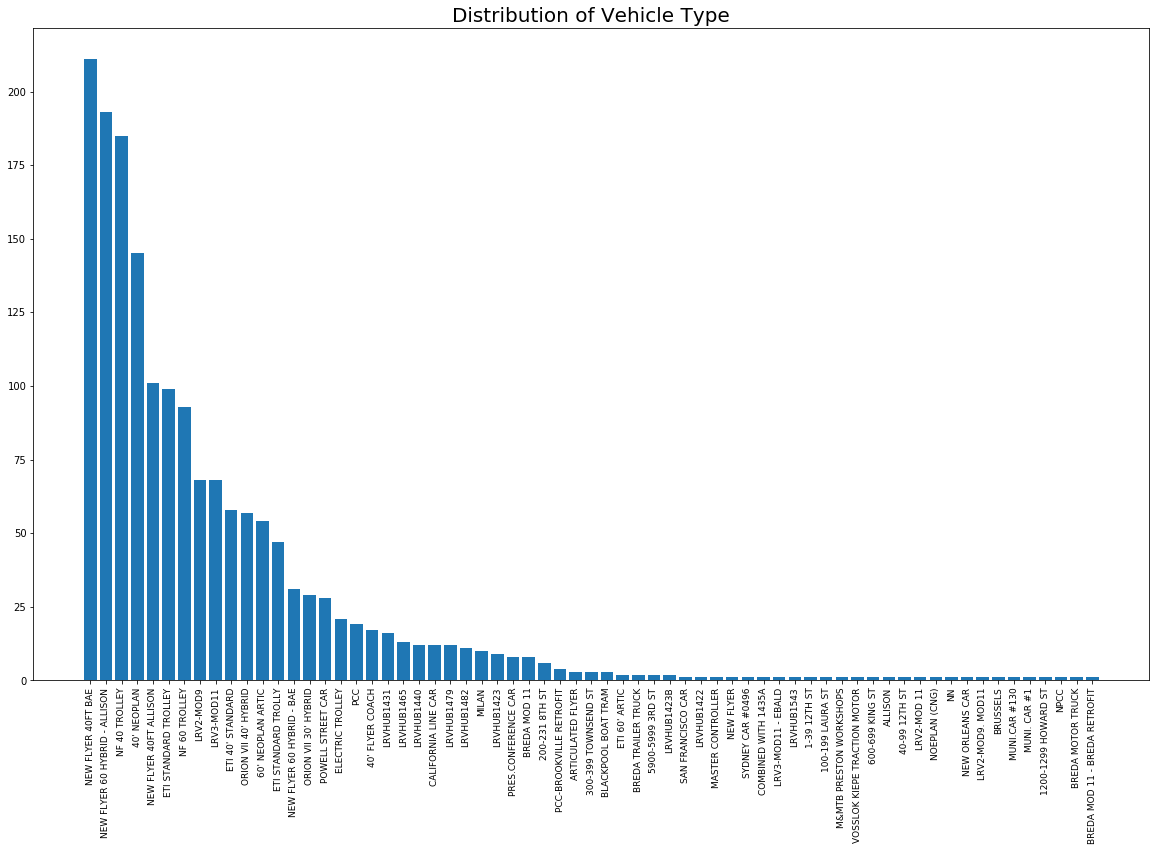

In [7]:
x = vehicle_types['EQUIP_NAME'].value_counts().index
y = vehicle_types['EQUIP_NAME'].value_counts().values

plt.figure(1, figsize=(20,12))
plt.bar(x, y)
plt.title("Distribution of Vehicle Type", fontsize=20)
plt.xticks(rotation=90, fontsize=9)
# fig = plt.gcf()
# fig.savefig('../../images/vehicle_types.pdf')
plt.show()

In [8]:
vehicle_types.groupby('EQUIP_NAME').head(vehicle_types.shape[0]).to_csv('../../temp_data/code_by_vehicle_name.csv', index=False)

## 2. Analysis of vehicle codes 

Observations from analyzing the vehicle code table:
1. Certain vehicle types occupy a range of numbers used as the identifying code. (i.e., 4000' classifies 40' FLYER COACH, where as 1800's correspond to MILAN)
2. One of the vehicle names is spelled 'ETI STANDARD TROLLY', where TROLLY is missing an 'E' at the end. This typo can explain why there is another vehicle type named 'ETI STANDARD TROLLEY'. We will correct the spelling error and combine the two into one vehicle type. 
3. Whenever the EQUIP_CODE jumps by a certain amount (roughly minimum of 20) it switches to identify a new vehicle type. 
4. PCC is possible short for PRES CONFERENCE CAR and not a truly different vehicle type. This is also likely due to the corresponding number id falling within the same range of 1000 - 1100. Change PCC to PRES.CONFERENCE CAR.  
5. Certain vehicle types may still be the same class of vehicles (i.e., TROLLEY, BUS, RAILCAR, etc) and therefore have comparable speeds.
6. POWELL STREET CAR and MUNI. CAR \#1 share the same EQUIP_CODE. Drop the MUNI. CAR \#1 since the range of numbers shared here (1-30) correspond to POWELL STREET CAR. 

In [2]:
# Load vehicle types
vehicle_types = pd.read_csv('../../temp_data/code_by_vehicle_name(edited).csv', usecols=[0,1])
print("Size of df: {}".format(vehicle_types.shape))
print("Number of unqiue v-types: {}".format(vehicle_types["EQUIP_NAME"].nunique()))
vehicle_types.head()

Size of df: (1688, 2)
Number of unqiue v-types: 62


,EQUIP_CODE,EQUIP_NAME
0,1,POWELL STREET CAR
1,2,POWELL STREET CAR
2,3,POWELL STREET CAR
3,4,POWELL STREET CAR
4,5,POWELL STREET CAR


In [3]:
vehicle_types.dtypes

EQUIP_CODE    object
EQUIP_NAME    object
dtype: object

In [4]:
vehicle_map = {}

for i, v in vehicle_types.values:
    vehicle_map[i] = v
    
print(len(vehicle_map))

1688


## 3. Map Vehicle type to one sample dataset

In [5]:
# Monthly speed data by region
region_data_dir = '../../temp_data/region_data/'

print('Number of region files: {}'.format(len(os.listdir(region_data_dir))))
files = os.listdir(region_data_dir)

Number of region files: 196


In [6]:
sample_df = pd.read_csv(region_data_dir + files[1])
print("Dimensions: {}".format(sample_df.shape))
print('Unique keys: {}'.format(sample_df['VEHICLE_TAG'].nunique()))
sample_df.head()

Dimensions: (160405, 9)
Unique keys: 505


,REV,REPORT_TIME,VEHICLE_TAG,LONGITUDE,LATITUDE,SPEED,geometry,index_right,geoid10
0,1513,2016-02-01 06:51:43,5403,-122.43606,37.79961,3.056,POINT (-122.43606 37.79960999999999),21,6075012800
1,1513,2016-02-01 08:59:05,5403,-122.43570,37.79811,2.500,POINT (-122.4357 37.79811),21,6075012800
2,1513,2016-02-01 09:00:35,5403,-122.43717,37.79680,1.944,POINT (-122.43717 37.7968),21,6075012800
3,1513,2016-02-01 11:18:21,5403,-122.43706,37.79635,6.111,POINT (-122.43706 37.79635),21,6075012800
4,1513,2016-02-01 13:04:39,5403,-122.43720,37.79650,4.444,POINT (-122.4372 37.7965),21,6075012800


In [7]:
sample_df['VEHICLE_NAME'] = sample_df['VEHICLE_TAG'].map(vehicle_map)
print('Unique vehicle names: {}'.format(sample_df['VEHICLE_NAME'].nunique()))

Unique vehicle names: 9


Clearly, not all vehicle tags mapped successfully. Check to see how many tags did not match to the vehicle type table

In [8]:
print("Non mapping vehicle tags: {}".format(sample_df[sample_df['VEHICLE_NAME'].isna()]['VEHICLE_TAG'].nunique()))
print(sorted(sample_df[sample_df['VEHICLE_NAME'].isna()]['VEHICLE_TAG'].unique()))

Non mapping vehicle tags: 84
['5401', '5402', '5403', '5406', '5411', '5412', '5418', '5423', '5426', '5427', '5431', '5434', '5439', '5459', '5464', '5468', '5481', '5488', '5507', '5511', '5512', '5516', '5522', '5531', '5532', '5537', '5564', '5591', '5602', '5620', '5623', '5636', '5640', '6204', '8001', '8004', '8009', '8011', '8014', '8015', '8017', '8024', '8026', '8027', '8032', '8042', '8104', '8111', '8112', '8122', '8137', '8139', '8140', '8147', '8179', '8187', '8190', '8191', '8204', '8213', '8219', '8220', '8226', '8228', '8229', '8235', '8309', '8311', '8315', '8335', '8340', '8343', '8348', '8350', '8355', '8357', '8358', '8359', '8360', '8366', 'T043', 'T280', 'T283', 'T286']


In [9]:
# Missing vehicle names
sample_df.isna().sum()

REV                 0
REPORT_TIME         0
VEHICLE_TAG         0
LONGITUDE           0
LATITUDE            0
SPEED               0
geometry            0
index_right         0
geoid10             0
VEHICLE_NAME    26494
dtype: int64

In [10]:
print("{:1.2f}% of values missing".format((26494 / sample_df.shape[0])*100))

16.52% of values missing


84 vehicle tags did not map to a vehicle name.

Further analyzing the vehicle types key, we see that vehicle id's tend to correspond to certain number ranges. It is likely that these missing numbers can be assigned a vehicle type fairly accurately since their number falls within range of a vehicle type. 

For now, we will simply keep the values that did not map to a vehicle type. Instead, with the entries that mapped to a specific vehicle type, we will analyze the distribution of their speed. 

Note: Although the patterns appear strong enough, this is still an assumption we are making with the dataset. In the future, a cleaner dataset can prevent issues such as this. 

In [11]:
def cust_hist(x, n_bins=20, **kwargs):
    bins = np.linspace(x.min(), x.max(), n_bins)
    plt.hist(x, bins, edgecolor='white', **kwargs)

<Figure size 432x288 with 0 Axes>

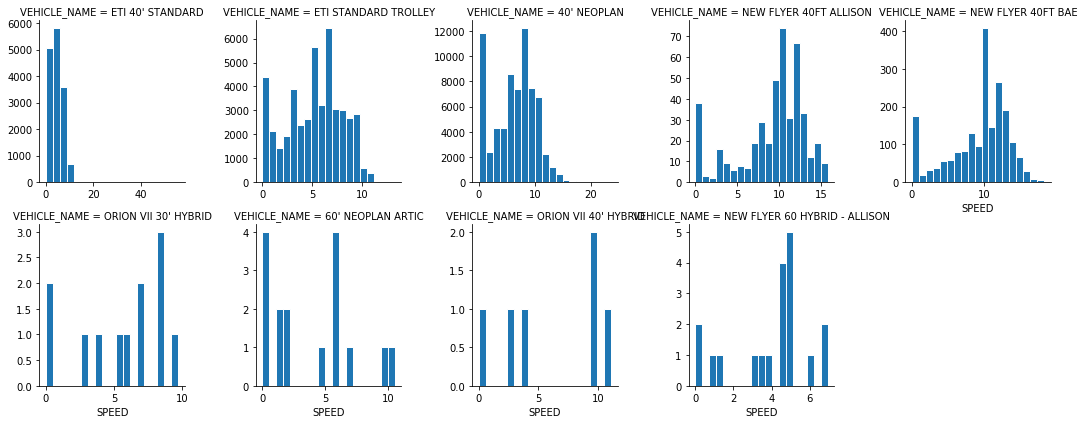

In [12]:
# 6075012800 - 1
plt.figure(2)
g = sns.FacetGrid(sample_df, col='VEHICLE_NAME', col_wrap=5, sharey=False, sharex=False)
g = g.map(cust_hist, "SPEED")
# g.savefig('../../images/region6075012800_by_vehicle_type.pdf')
plt.show()

In [13]:
ETI40 = sample_df[sample_df['VEHICLE_NAME'] == "ETI 40' STANDARD"]

In [14]:
max(ETI40['SPEED'])

55.833

Some vehicle types have speeds in the 55 m/s. 
55m/s translates to around 120+ mph. It is very unlikely for a public transportation vehicle to be traveling at these speeds, thus we can consider this an outlier/error with the speed recording system. 

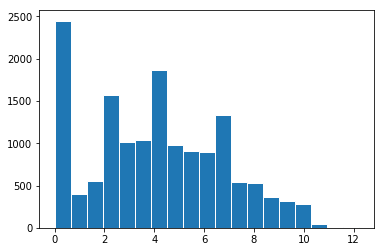

In [15]:
cust_hist(ETI40[ETI40['SPEED'] <= 35]['SPEED'], n_bins = 20)

There seems to be a high number of 0s. Since we do not know how to interpret these values, we cannot remove these values as they could be meaningful (i.e, could indicate traffic stops when all vehicles stop)

## 4. Observe Distribution of Vehicle Speed by Vehicle type for all monthly data (feb 2016)

In [16]:
main_df = pd.read_csv(region_data_dir + files[0], usecols=['SPEED', 'VEHICLE_TAG'], dtype={'SPEED': np.float,'VEHICLE_TAG': str})

size = []
size.append(main_df.shape[0])

for i in files[1:]:
    sample_df = pd.read_csv(region_data_dir + i, usecols=['SPEED', 'VEHICLE_TAG'], dtype={'SPEED': np.float, 'VEHICLE_TAG': str})
    size.append(sample_df.shape[0])
    main_df = pd.concat([main_df, sample_df], axis=0, ignore_index=True)
    
print("Total number of rows combined: {}".format(sum(size)))

main_df.to_csv("../../temp_data/all_speeds_feb_2016.csv", index=False)

Total number of rows combined: 33350866


In [ ]:
# main_df = pd.read_csv("../../temp_data/all_speeds_feb_2016.csv")

In [17]:
main_df.columns = ['KEY', 'SPEED']
print(main_df.dtypes)
print("Dimensions: {}".format(main_df.shape))
print('Unique keys: {}'.format(main_df['KEY'].nunique()))
main_df.head()

KEY       object
SPEED    float64
dtype: object
Dimensions: (33350866, 2)
Unique keys: 1261


,KEY,SPEED
0,5486,0.000
1,5486,0.000
2,5486,3.056
3,5494,10.556
4,5494,10.278


In [18]:
# Check sparsity of data
main_df.isna().sum()

KEY      0
SPEED    0
dtype: int64

In [19]:
# Map vehicle type to key
main_df['VEHICLE_NAME'] = main_df['KEY'].map(vehicle_map)
print("Dimensions: {}".format(main_df.shape))
print("Unique vehicle names: {}".format(main_df['VEHICLE_NAME'].nunique()))
main_df.head()

Dimensions: (33350866, 3)
Unique vehicle names: 27


,KEY,SPEED,VEHICLE_NAME
0,5486,0.000,ETI STANDARD TROLLEY
1,5486,0.000,ETI STANDARD TROLLEY
2,5486,3.056,ETI STANDARD TROLLEY
3,5494,10.556,ETI STANDARD TROLLEY
4,5494,10.278,ETI STANDARD TROLLEY


In [20]:
main_df.isna().sum()

KEY                   0
SPEED                 0
VEHICLE_NAME    4938340
dtype: int64

In [21]:
print("{:1.2f}% of values missing".format((main_df.isna().sum().values[-1] / main_df.shape[0])*100))

14.81% of values missing


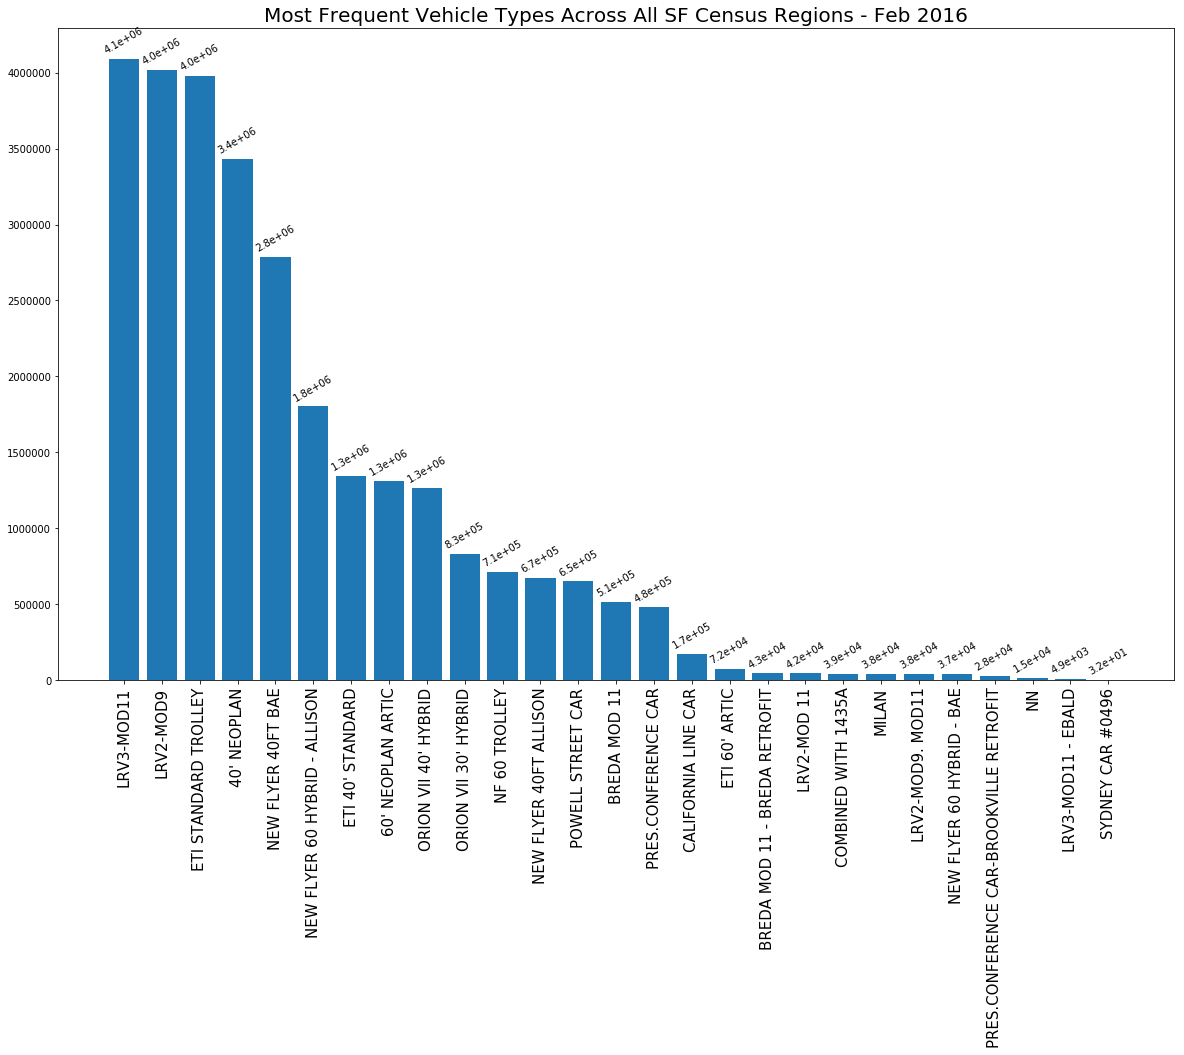

In [22]:
# See the number of times a vehicle appears
x = main_df['VEHICLE_NAME'].value_counts().index
y = main_df['VEHICLE_NAME'].value_counts().values
plt.figure(3, figsize=(20,12))
fig = plt.bar(x, y)
plt.title("Most Frequent Vehicle Types Across All SF Census Regions - Feb 2016", fontsize=20)
plt.xticks(rotation=90, fontsize=15)
for rects in fig.patches:
    # y-axis value
    height = rects.get_height()
    plt.text(rects.get_x()+rects.get_width()/2.0,
            height+170000,
            '{:.1e}'.format(height),
            ha='center',
            rotation=30,
            fontsize=10)

# fig = plt.gcf()
# fig.savefig('../../images/frequency_of_vehicle_types_feb_2016.pdf')
plt.show()

In [23]:
print("Non mapping vehicle tags: {}".format(main_df[main_df['VEHICLE_NAME'].isna()]['KEY'].nunique()))
print(sorted(main_df[main_df['VEHICLE_NAME'].isna()]['KEY'].unique()))

Non mapping vehicle tags: 369
['401', '402', '403', '404', '405', '406', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419', '420', '421', '422', '423', '424', '425', '426', '427', '428', '429', '430', '431', '432', '433', '434', '435', '436', '437', '438', '439', '440', '441', '442', '443', '444', '445', '446', '447', '448', '449', '450', '451', '452', '453', '454', '455', '456', '457', '458', '459', '460', '461', '462', '463', '464', '465', '466', '467', '468', '469', '470', '471', '472', '473', '474', '475', '476', '477', '478', '479', '480', '481', '482', '483', '484', '485', '486', '487', '488', '489', '490', '491', '492', '493', '494', '495', '497', '498', '499', '500', '5401', '5402', '5403', '5406', '5411', '5412', '5418', '5423', '5426', '5427', '5431', '5434', '5439', '5459', '5464', '5468', '5481', '5488', '5507', '5511', '5512', '5516', '5522', '5531', '5532', '5537', '5564', '5591', '5602', '5620', '5623', '5632', '5636', '5640', '620

<Figure size 432x288 with 0 Axes>

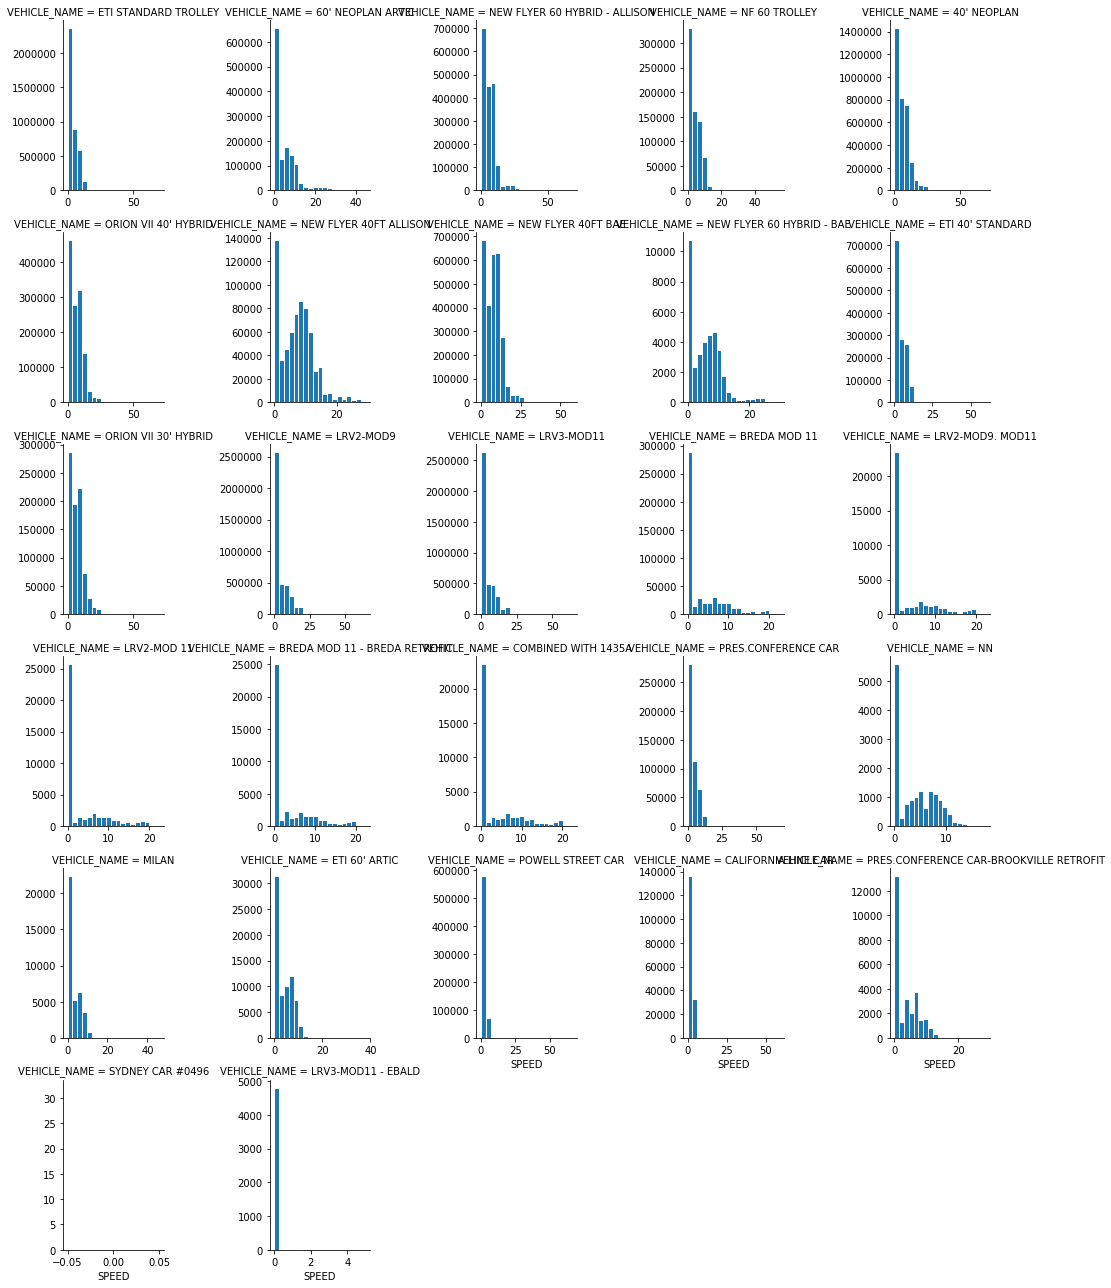

In [24]:
plt.figure(4)
g = sns.FacetGrid(main_df, col='VEHICLE_NAME', col_wrap=5, sharey=False, sharex=False)
g = g.map(cust_hist, "SPEED")
# g.savefig('../../images/speed_by_vehicle_type_feb_2016.pdf')
plt.show()

## 5. Filter data

In [25]:
# Calculate the mean speed and standard deviation
mean = np.mean(main_df['SPEED'])
std = np.std(main_df['SPEED'])
maximum = max(main_df['SPEED'])
print("Mean: {:.2f}".format(mean))
print("Standard deviation: {:.2f}".format(std))
print("Maximum speed: {}m/s".format(maximum))

Mean: 4.45
Standard deviation: 5.05
Maximum speed: 69.444m/s


Detect extreme outliers - defined as 3 times the IQR below the first quantile or above the third quantile.   
$x < Q1 - 3 \times IQR$  
$x > Q3 + 3 \times IQR$

In [26]:
q1, q2, q3 = np.percentile(main_df['SPEED'], [25, 50, 75])
print("Q1: {}, Q2:{}, Q3: {}".format(q1, q2, q3))

Q1: 0.0, Q2:3.333, Q3: 7.5


In [27]:
iqr = q3 - q1
ex_outlier = q3 + 3 * iqr
print("Extreme outliers: x > {}".format(ex_outlier))

Extreme outliers: x > 30.0


This translates to around 67.10 mph

In [28]:
filtered_df = main_df[main_df['SPEED'] <= ex_outlier].reset_index(drop=True)
print("Dimensions: {}".format(filtered_df.shape))
print("Rows removed: {} or {:.5f}%".format(main_df.shape[0] - filtered_df.shape[0], ((main_df.shape[0] - filtered_df.shape[0])/main_df.shape[0])*100))

Dimensions: (33348449, 3)
Rows removed: 2417 or 0.00725%


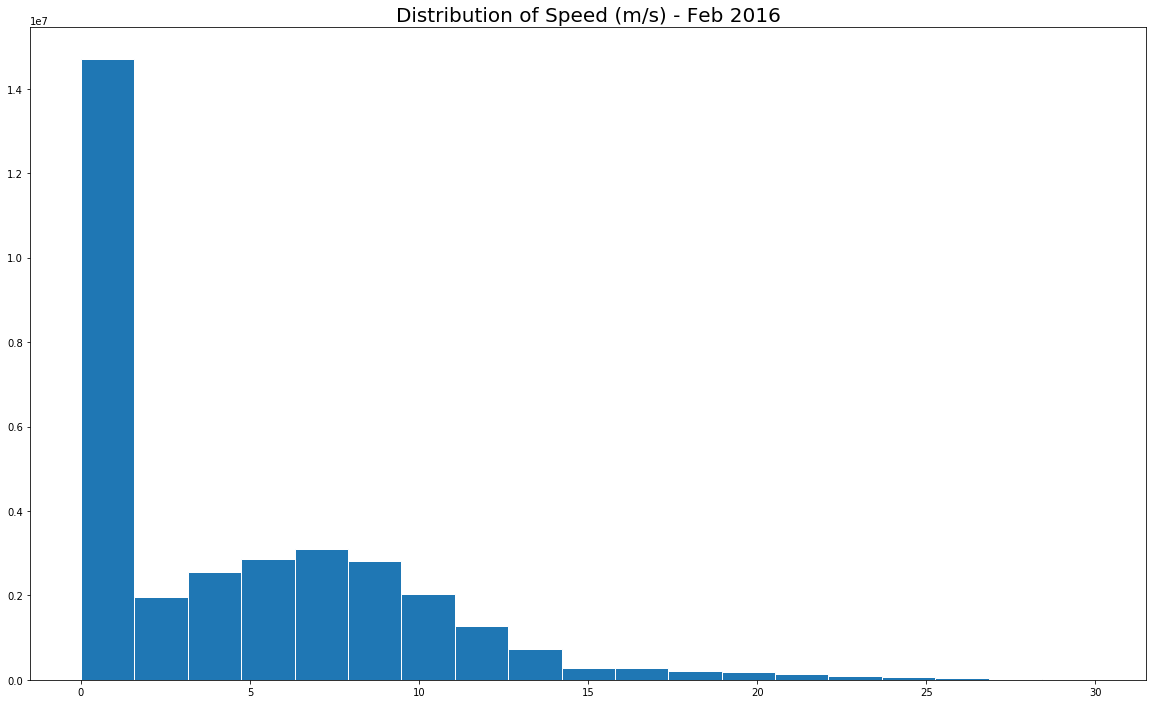

In [29]:
plt.figure(5, figsize=(20,12))
cust_hist(filtered_df['SPEED'], n_bins=20)
plt.title("Distribution of Speed (m/s) - Feb 2016", fontsize=20)
# fig = plt.gcf()
# fig.savefig("../../images/distribution_of_speed_feb_2016")
plt.show()

<Figure size 432x288 with 0 Axes>

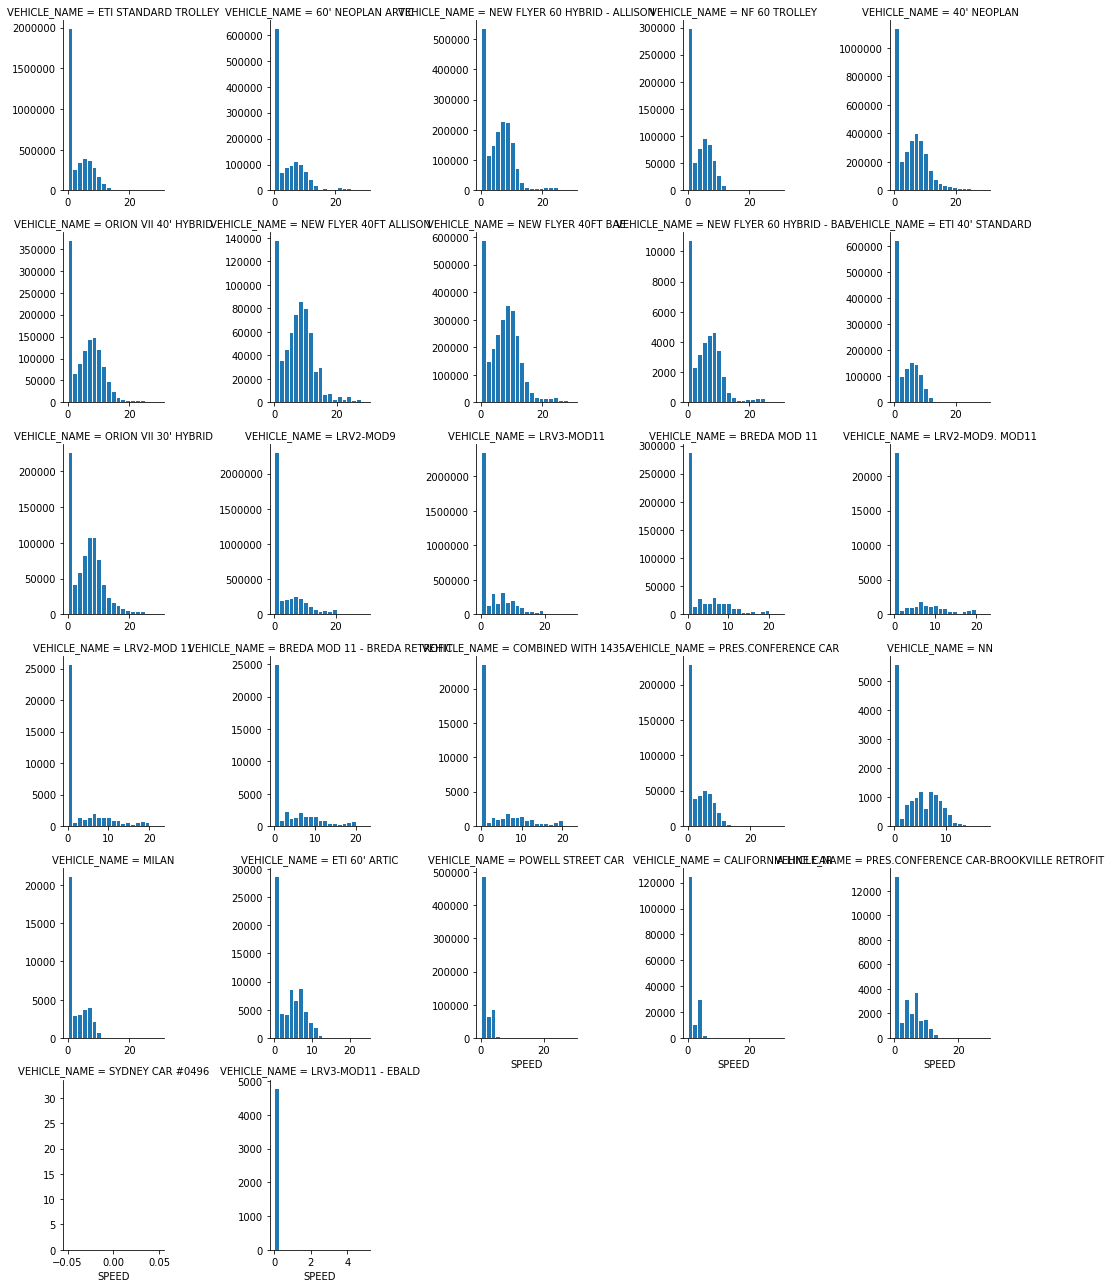

In [54]:
plt.figure(6)
g = sns.FacetGrid(filtered_df, col='VEHICLE_NAME', col_wrap=5, sharey=False, sharex=False)
g = g.map(cust_hist, "SPEED")
# g.savefig('../../images/speed_by_vehicle_type_feb_2016(filtered).pdf')
plt.show()

Find Vehicles with questionable speeds (mostly in 0 range).
If they are mostly 0 speed consider removing them from the data as it will severely skew the average speed of each region.

Generate higher resolution histograms for the following vehicle types:
1. POWELL STREET CAR
2. CALIFORNIA LINE CAR
3. SYDNEY CAR #0496
4. LRV3-MOD11 - EBALD

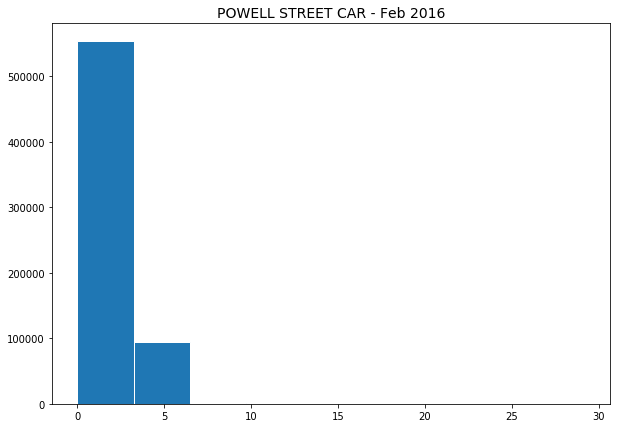

In [30]:
plt.figure(7, figsize=(10,7))
cust_hist(filtered_df[filtered_df["VEHICLE_NAME"] == "POWELL STREET CAR"]["SPEED"], n_bins=10)
plt.title("POWELL STREET CAR - Feb 2016", fontsize=14)
plt.show()

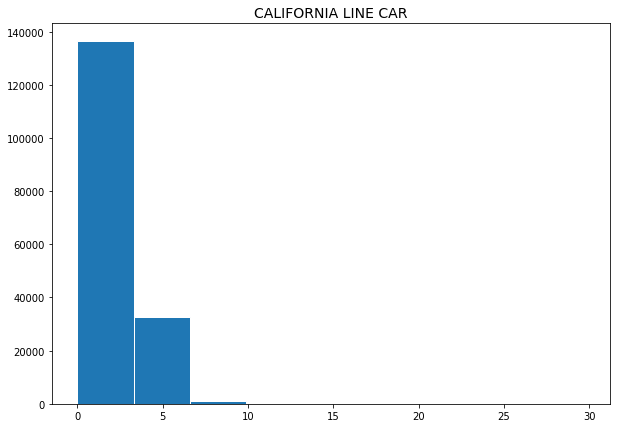

In [31]:
plt.figure(8, figsize=(10,7))
cust_hist(filtered_df[filtered_df["VEHICLE_NAME"] == "CALIFORNIA LINE CAR"]["SPEED"], n_bins=10)
plt.title("CALIFORNIA LINE CAR", fontsize=14)
plt.show()

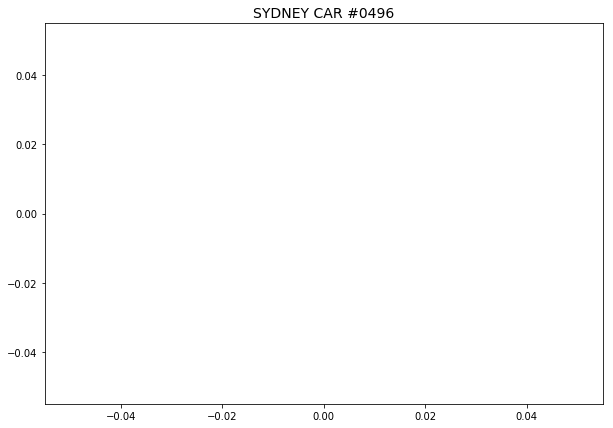

In [32]:
plt.figure(9, figsize=(10,7))
cust_hist(filtered_df[filtered_df["VEHICLE_NAME"] == "SYDNEY CAR #0496"]["SPEED"], n_bins=1)
plt.title("SYDNEY CAR #0496", fontsize=14)
plt.show()

In [33]:
# Check speed values
filtered_df[filtered_df["VEHICLE_NAME"] == "SYDNEY CAR #0496"]["SPEED"].value_counts()

0.0    32
Name: SPEED, dtype: int64

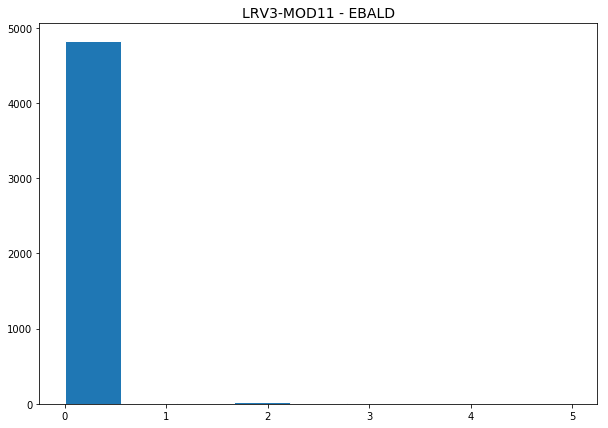

In [34]:
plt.figure(10, figsize=(10,7))
cust_hist(filtered_df[filtered_df["VEHICLE_NAME"] == "LRV3-MOD11 - EBALD"]["SPEED"], n_bins=10)
plt.title("LRV3-MOD11 - EBALD", fontsize=14)
plt.show()

The California Line and Powell street car are both cable cars. Unlike buses and cars, cable cars operate on designated tracks and have relatively low speeds.  
We can expect these vehicle types to appear only in certain census regions.

Additionally, over the month of Feb, SYDNEY CAR #0496 only had speed readings of 0m/s, so we will remove this vehicle type. 

Additionally, we will remove LRV3-MOD11-EBALD as majority of its speed is well below 1 m/s. 

## 6. Filter all region speed datasets

In [35]:
# Monthly speed data by region
region_data_dir = '../../temp_data/region_data/'

print('Number of region files: {}'.format(len(os.listdir(region_data_dir))))
files = os.listdir(region_data_dir)

Number of region files: 196


NOTE: This steps takes a while depending on hardware (anywhere from 10 to 15+ minutes)

In [36]:
size = [] # Count total number of rows read
weights = {} # Create region: size weight dictionary 

excluded_v_types = ["SYDNEY CAR #0496", "LRV3-MOD11 - EBALD"]

for n, i in enumerate(files):
    data_table = pd.read_csv(region_data_dir + i, dtype={"VEHICLE_TAG": str})
    size.append(data_table.shape[0])
    data_table["VEHICLE_NAME"] = data_table["VEHICLE_TAG"].map(vehicle_map)
    
    # Filter out extreme outliers
    data_table_f = data_table[data_table['SPEED'] <= ex_outlier].reset_index(drop=True)
    
    # Filter out excluded vehicle types
    data_table_f = data_table_f[~data_table_f["VEHICLE_NAME"].isin(excluded_v_types)].reset_index(drop=True)
    
    weights[re.sub("time_series_|\.csv", "", i)] = data_table_f.shape[0]
    
    data_table_f.to_csv("../../temp_data/region_data_filtered/filtered_{}".format(i), index=False)
    difference = data_table.shape[0] - data_table_f.shape[0]
    print("#{}. {} - finished filtering - {} original # of rows - {} row(s) removed - {:.5f}% reduction".format(n, i, data_table.shape[0], difference, (difference / data_table.shape[0])*100))

print('****DONE. Total number of rows read: {}****'.format(sum(size)))

#0. time_series_region_6075047801.csv - finished filtering - 98216 original # of rows - 1 row(s) removed - 0.00102% reduction
#1. time_series_region_6075012800.csv - finished filtering - 160405 original # of rows - 1 row(s) removed - 0.00062% reduction
#2. time_series_region_6075021400.csv - finished filtering - 47769 original # of rows - 1 row(s) removed - 0.00209% reduction
#3. time_series_region_6075025100.csv - finished filtering - 129054 original # of rows - 15 row(s) removed - 0.01162% reduction
#4. time_series_region_6075042602.csv - finished filtering - 94047 original # of rows - 0 row(s) removed - 0.00000% reduction
#5. time_series_region_6075023001.csv - finished filtering - 105617 original # of rows - 54 row(s) removed - 0.05113% reduction
#6. time_series_region_6075030900.csv - finished filtering - 267029 original # of rows - 4 row(s) removed - 0.00150% reduction
#7. time_series_region_6075013101.csv - finished filtering - 51107 original # of rows - 1 row(s) removed - 0.001

Use the number of recorded speed (rows) as a measure of 'regional activity'. The more rows there are, the higher the acitvity of a region.   
Note: This is over the course of the entire month of Feburary. Depending on different granularity, the level of activity among regions can fluctuate. 

In [37]:
# save weights as pickle file
pickle.dump(weights, open("../../output/region_weights.p", "wb"))

# save weight as csv
with open("../../output/region_weights.csv", "w") as outfile:
    writer = csv.writer(outfile)
    for k, v in weights.items():
        writer.writerow([k,v])

## 7. Dealing with infrequent timesteps

In [38]:
# Monthly speed data by region
region_data_dir = '../../temp_data/region_data_filtered/'

print('Number of region files: {}'.format(len(os.listdir(region_data_dir))))
files = os.listdir(region_data_dir)

Number of region files: 196


In [39]:
sample_df = pd.read_csv(region_data_dir + files[0], parse_dates=["REPORT_TIME"], infer_datetime_format=True)
print("Region: {}".format(files[0]))
print("Dimensions: {}".format(sample_df.shape[0]))
sample_df.head()

Region: filtered_time_series_region_6075026301.csv
Dimensions: 101801


,REV,REPORT_TIME,VEHICLE_TAG,LONGITUDE,LATITUDE,SPEED,geometry,index_right,geoid10,VEHICLE_NAME
0,1513,2016-02-01 15:29:32,5405,-122.44243,37.71479,7.500,POINT (-122.44243 37.71479),148,6075026301,ETI 40' STANDARD
1,1513,2016-02-01 22:13:12,5405,-122.44171,37.71552,9.167,POINT (-122.44171 37.71552),148,6075026301,ETI 40' STANDARD
2,1513,2016-02-01 03:26:31,5411,-122.44152,37.71577,9.167,POINT (-122.44152 37.71577),148,6075026301,NaN
3,1513,2016-02-01 03:27:44,5411,-122.44076,37.71678,0.000,POINT (-122.44076 37.71678),148,6075026301,NaN
4,1513,2016-02-01 05:17:11,5411,-122.44177,37.71544,10.278,POINT (-122.44177 37.71544),148,6075026301,NaN


In [40]:
sample_df[sample_df["VEHICLE_TAG"] == str(5411)]

,REV,REPORT_TIME,VEHICLE_TAG,LONGITUDE,LATITUDE,SPEED,geometry,index_right,geoid10,VEHICLE_NAME
2,1513,2016-02-01 03:26:31,5411,-122.44152,37.71577,9.167,POINT (-122.44152 37.71577),148,6075026301,NaN
3,1513,2016-02-01 03:27:44,5411,-122.44076,37.71678,0.000,POINT (-122.44076 37.71678),148,6075026301,NaN
4,1513,2016-02-01 05:17:11,5411,-122.44177,37.71544,10.278,POINT (-122.44177 37.71544),148,6075026301,NaN
34759,1514,2016-02-13 02:25:02,5411,-122.44391,37.71337,6.944,POINT (-122.44391 37.71337),148,6075026301,NaN
34760,1514,2016-02-13 02:25:18,5411,-122.44311,37.71413,6.667,POINT (-122.44311 37.71413),148,6075026301,NaN
34761,1514,2016-02-13 02:25:30,5411,-122.44253,37.71469,6.111,POINT (-122.44253 37.71469),148,6075026301,NaN
34762,1514,2016-02-13 02:26:02,5411,-122.44125,37.71610,3.889,POINT (-122.44125 37.7161),148,6075026301,NaN
34763,1514,2016-02-13 02:26:48,5411,-122.44102,37.71641,4.444,POINT (-122.44102 37.71641),148,6075026301,NaN
56999,1514,2016-02-19 08:57:05,5411,-122.44376,37.71353,11.667,POINT (-122.44376 37.71353),148,6075026301,NaN
57000,1514,2016-02-19 08:57:14,5411,-122.44295,37.71429,10.278,POINT (-122.44295 37.71429000000001),148,6075026301,NaN


In [41]:
dict(enumerate(sample_df.columns))

{0: 'REV',
 1: 'REPORT_TIME',
 2: 'VEHICLE_TAG',
 3: 'LONGITUDE',
 4: 'LATITUDE',
 5: 'SPEED',
 6: 'geometry',
 7: 'index_right',
 8: 'geoid10',
 9: 'VEHICLE_NAME'}

Vehicles are identified with unique vehicle tags. From studying the data, we can see that certain vehicles are only operating on certan days. 
By aggregating the speeds for the entire hour in a particular region, we lose the granularity of unique vehicle speeds in that region for a given time period. By taking this aggregation step, however, we hope to simplify the data while still capturing the **overall traffic conditions** of a region for a given hour. 

Our rationale for this aggregation:
1. If an area is experiencing high traffic congenstion, we suspect all vehicles in that given region to be impacted and experience a similar slowdown. 
2. Likewise, if an area is congenstion free, we suspect all vehicles in that region to be running close to their normal operating speeds. 

As observed from the exploratory analysis, the dataset contains several errors and inconsistencies. The aggregation, in exchange for losing granularity, may help mask some of this inconsistencies while allowing us to generate a model to predict the generalized speed of a region.

In the future, when higher quality data is available, developing models to generate predictions for each vehicle may be possible. 

It is important to note that the speeds of the vehicles provided by sfmta are from all their transportation vehicles in operation which include buses, trolley cars, cable cars, taxi's, etc. We are aware of the issue of natural differences in speed being present (i.e, Cable cars operate much slower than buses or taxis). However, with the given data, we are unable to accurately find and partition the dataset by vehicle type. 

Additionally, certain regions within SF have dominantly operating vehicles. ('i.e., Cable cars operate in defined regions, buses have specific routes, etc.) Thus, the region level granularity may help us account for the difference in speed by vehicle type to some extent). 

In [42]:
# Apply timer
region_by_time_generator = timer(region_by_time_generator)

In [43]:
time_series = region_by_time_generator(region_data_dir, usecols=[1,5])

Running region_by_time_generator...
Reading files from directory: ../../temp_data/region_data_filtered/
Finished in 62.2268s


In [44]:
print("Dimensions: {}".format(time_series.shape))
time_series.head()

Dimensions: (196, 697)


REPORT_TIME,2016-02-01 00:00:00,2016-02-01 01:00:00,2016-02-01 02:00:00,2016-02-01 03:00:00,2016-02-01 04:00:00,2016-02-01 05:00:00,2016-02-01 06:00:00,2016-02-01 07:00:00,2016-02-01 08:00:00,2016-02-01 09:00:00,...,2016-02-29 15:00:00,2016-02-29 16:00:00,2016-02-29 17:00:00,2016-02-29 18:00:00,2016-02-29 19:00:00,2016-02-29 20:00:00,2016-02-29 21:00:00,2016-02-29 22:00:00,2016-02-29 23:00:00,2016-03-01 00:00:00
region_6075010100,1.103094,0.850827,0.137040,0.078909,0.196874,1.539069,1.714272,2.258792,1.799093,2.151459,...,2.239105,2.471772,2.591621,2.202300,1.242359,1.202609,0.981914,1.050426,1.368480,0.0
region_6075010200,4.474976,6.177880,7.323182,6.249900,5.763750,4.905341,4.557325,3.481254,1.850865,2.825775,...,2.734535,2.477057,2.435120,3.243975,3.458722,2.948414,2.544947,2.356152,2.466459,NaN
region_6075010300,5.635000,5.944400,8.889000,1.620333,NaN,5.532250,4.415793,4.503976,4.671350,5.090225,...,4.047194,4.435053,4.571130,4.656116,4.763261,5.180390,5.349852,4.901961,4.934529,NaN
region_6075010400,5.674429,9.444333,6.944000,7.500000,12.778000,5.926167,4.881000,5.593897,3.988920,6.063925,...,4.736745,4.836363,4.627703,4.603434,4.804670,4.637204,5.731026,4.656882,4.882050,NaN
region_6075010500,3.446908,6.550136,4.444000,0.000000,5.799818,5.608138,4.122118,4.304811,4.170099,4.161973,...,4.107213,3.237954,2.903063,3.350814,3.964277,4.254140,4.476809,4.541343,4.188110,NaN


## 8. Remove outliers

Drop the last column for March

In [45]:
last_col = time_series.columns.tolist()[-1]
time_series.drop(axis=1, columns=last_col, inplace=True)
print("Dimensions: {}".format(time_series.shape))

Dimensions: (196, 696)


In [46]:
# Total number of cells
total = np.prod(time_series.shape)
# Get number of missing cells
missing = sum(time_series.isna().sum().values)
print("Total nan cells: {} out of {} or {:.2f}%".format(missing, total, (missing / total) * 100))

Total nan cells: 3268 out of 136416 or 2.40%


We have a dense matrix. Lets see how by region missing values are distributed. 

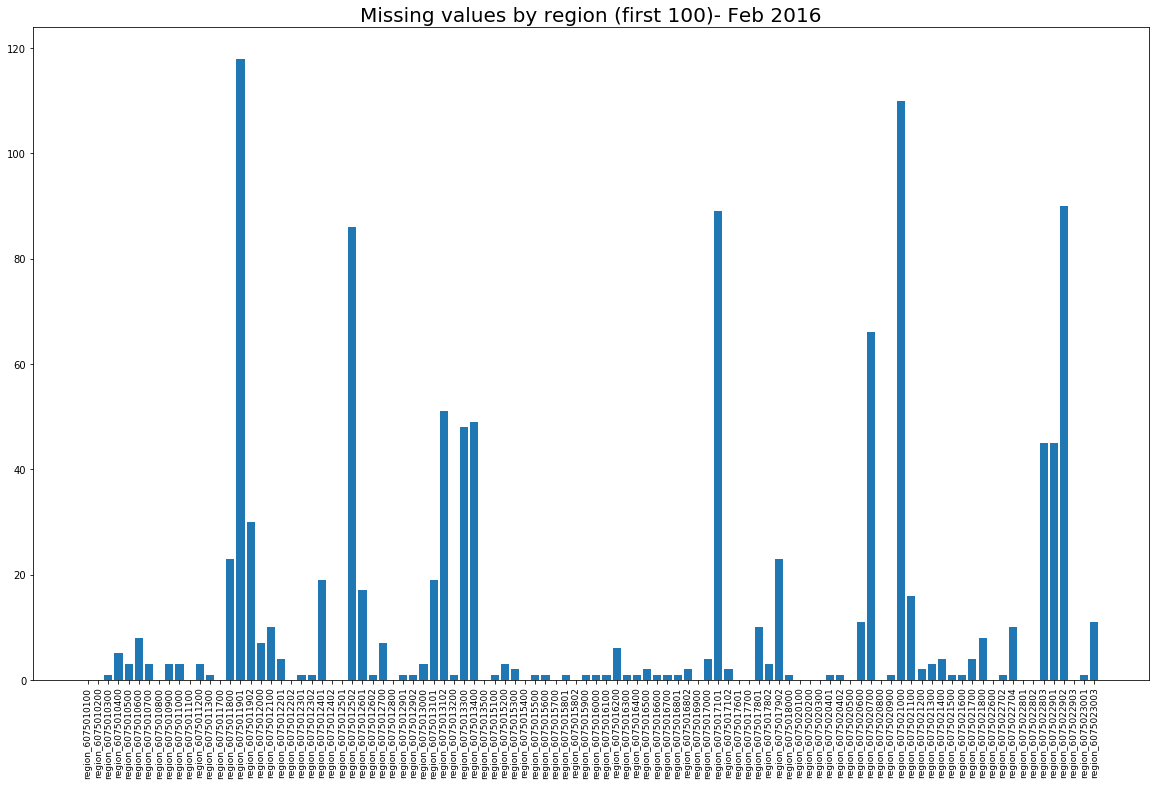

In [47]:
# Number of missing values by row
x = time_series.isna().sum(axis=1).index[:100]
y = time_series.isna().sum(axis=1).values[:100]
plt.figure(11, figsize=(20,12))
plt.bar(x, y)
plt.title("Missing values by region (first 100)- Feb 2016", fontsize=20)
plt.xticks(rotation=90, fontsize=9)
# fig = plt.gcf()
# fig.savefig("../../images/missing_values_by_region_feb_2016_first_100.pdf")
plt.show()

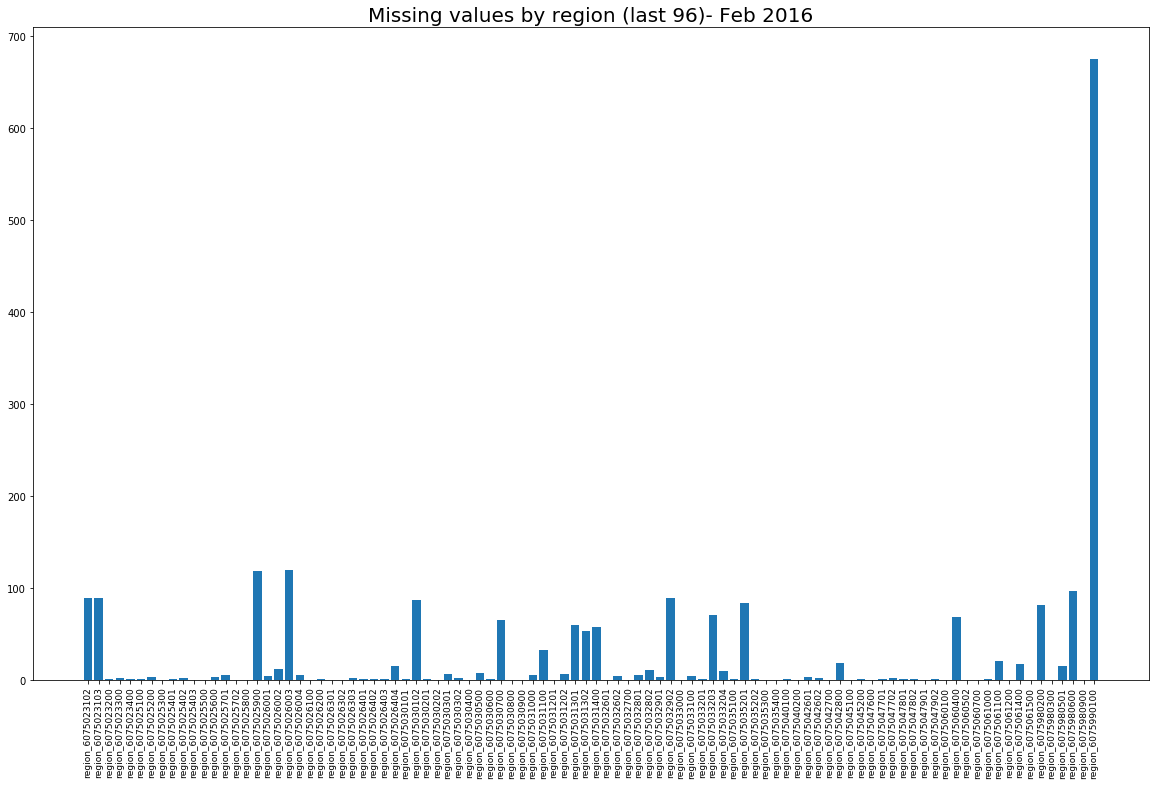

In [48]:
# Number of missing values by row
x = time_series.isna().sum(axis=1).index[100:]
y = time_series.isna().sum(axis=1).values[100:]
plt.figure(11, figsize=(20,12))
plt.bar(x, y)
plt.title("Missing values by region (last 96)- Feb 2016", fontsize=20)
plt.xticks(rotation=90, fontsize=9)
# fig = plt.gcf()
# fig.savefig("../../images/missing_values_by_region_feb_2016_first_100.pdf")
plt.show()

Since these regions were aggregated by 1 hour, if there was no activity during this entire hour, it suggested that sfmta vehicles were not operational during that time. Fill these values with 0 as there is no vehicle activity during this time. 

There is one clear outlier here which has majority of row values be missing. Take a closer look at this region to see what the time series looks like.

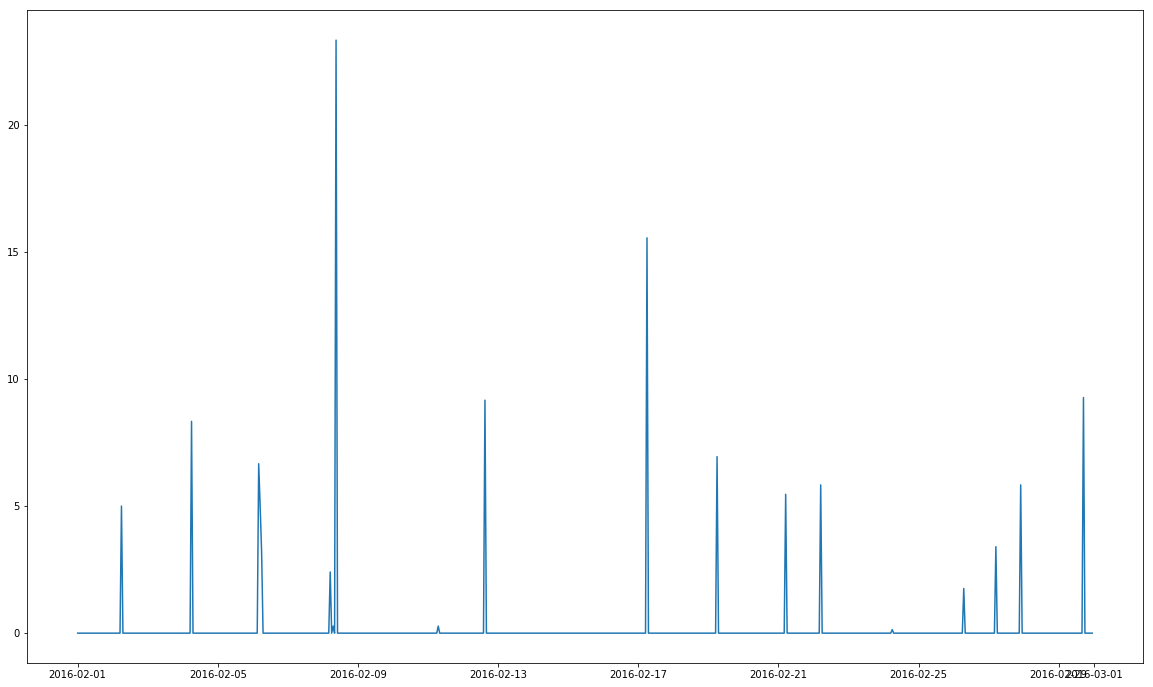

In [50]:
time_series_zeros = time_series.fillna(0)
plt.figure(12, figsize=(20,12))
plt.plot(time_series_zeros.loc["region_6075990100",:])
plt.show()

Lets further check and see where in SF this region maps to.

In [51]:
census_zones = gpd.GeoDataFrame.from_file("../../temp_data/sf_GEOID_GIS_data.shp")
print("Dimensions: {}".format(census_zones.shape))
census_zones.head()

Dimensions: (196, 2)


,geoid10,geometry
0,6075016500,"POLYGON ((-122.446471 37.775802, -122.44478 37..."
1,6075016400,"POLYGON ((-122.44034 37.77658, -122.439844 37...."
2,6075016300,"POLYGON ((-122.429152 37.778007, -122.428909 3..."
3,6075016100,"POLYGON ((-122.428909 37.778039, -122.429152 3..."
4,6075016000,"POLYGON ((-122.420425 37.780583, -122.420336 3..."


In [47]:
# Get geoid
geoid = census_zones['geoid10']
# Arbitray series of size N
color_val = pd.Series([0] * 196, name='color_val')
# Initalize color df 
color_df = pd.concat([geoid, color_val], axis=1, ignore_index=False)
color_df['geoid10'] = color_df['geoid10'].astype(int)
# color_df.set_index(keys="geoid10", inplace=True)
print(color_df.shape)
color_df.head()

(196, 2)


,geoid10,color_val
0,6075016500,0
1,6075016400,0
2,6075016300,0
3,6075016100,0
4,6075016000,0


In [48]:
# Change the color val or row where geoid corresponds to 6075010900 
row = color_df[color_df["geoid10"] == 6075990100].index
color_df.iloc[row, 1] = 1

In [49]:
census_zones = census_zones.merge(color_df, on="geoid10")
print("Dimensions; {}".format(census_zones.shape))
census_zones.head()

Dimensions; (196, 3)


,geoid10,geometry,color_val
0,6075016500,"POLYGON ((-122.446471 37.775802, -122.44478 37...",0
1,6075016400,"POLYGON ((-122.44034 37.77658, -122.439844 37....",0
2,6075016300,"POLYGON ((-122.429152 37.778007, -122.428909 3...",0
3,6075016100,"POLYGON ((-122.428909 37.778039, -122.429152 3...",0
4,6075016000,"POLYGON ((-122.420425 37.780583, -122.420336 3...",0


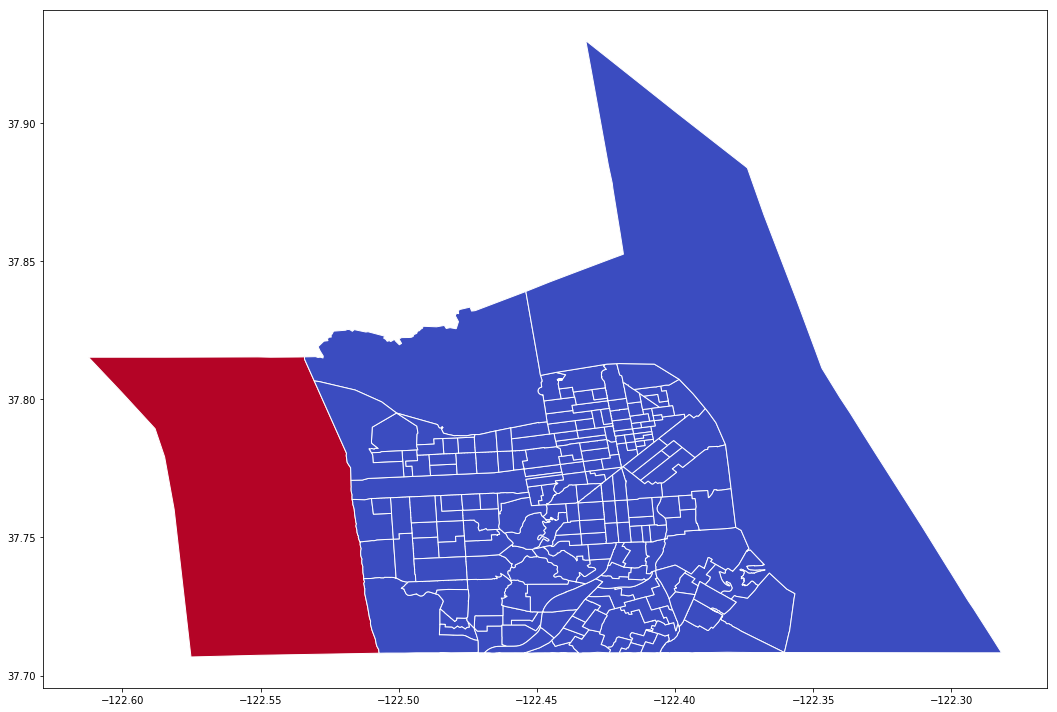

In [50]:
# plot the shapefile/GeoDataFrame
# Set coordinate reference system
census_zones.crs = {'init': 'epsg:4326'}
g = census_zones.plot(column='color_val', vmin=0, vmax=1, cmap='coolwarm', edgecolor='white', figsize=(18, 18))

# Get lat - lon coordinate for point of interest 
# lat, lon = sf_census_zones[sf_census_zones.geoid10 == 6075010900][['intptlat10', 'intptlon10']].values[0]
# g.annotate(s='{}, {}, {}'.format(lat, lon, address), xy=(lat, lon))

# plt.savefig('../../output/High_traffic_zone.png')
plt.show()

Image obtained from [Data SF](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Census-2010-Tracts-for-San-Francisco/rarb-5ahf)

![census_map](../../images/census_map.png)

Geographically, this region corresponds to water where no vehicle should be able to drive. Remove this area completely as it is too sparse. 

In [52]:
# Remove from region table
time_series_filtered = time_series.drop(axis=0, index="region_6075990100")
print("Dimensions: {}".format(time_series_filtered.shape))

# Total number of cells
total = np.prod(time_series_filtered.shape)
# Get number of missing cells
missing = sum(time_series_filtered.isna().sum().values)
print("Total nan cells: {} out of {} or {:.2f}%".format(missing, total, (missing / total) * 100))

Dimensions: (195, 696)
Total nan cells: 2592 out of 135720 or 1.91%


In [57]:
# Fill nan values with 0
time_series_filtered.fillna(0, inplace=True)

In [58]:
time_series_filtered.to_csv("../../output/region_time_series_filtered.csv")

In [53]:
# Remove the region from the graph we created in the notebook: census_zones_graph
G = nx.read_gpickle('../../output/census.gpickle')
print('Graph stats:')
print('Number of nodes: {}'.format(G.number_of_nodes()))
print('Number of edges: {}'.format(G.number_of_edges()))

Graph stats:
Number of nodes: 196
Number of edges: 612


In [54]:
lookup_geoid(G, 6075990100)

[21]

In [55]:
G.remove_node(21)

In [59]:
# Save graph as pickle file
nx.write_gpickle(G, '../../output/census_filtered.gpickle')